补偿的思路很简单，既然少数类吃亏了，就在输出的时候对其进行一定的补偿，补偿的方式主要分为两种：   

（1）一种是乘法补偿，对少数类的输出概率乘以一个大于1的数值；   

（2）另一种是加法补偿，对其概率加上某一个值   

下面简单介绍下补偿细节：  

### 基于经验的决策输出补偿

#### 1.乘法补偿
对少数类乘以不平衡比例：  

$$
IR=\frac{N_-}{N_+}
$$

#### 2.加法补偿
对概率分布加上如下的补偿值：   

$$
\theta=\frac{N_--N_+}{N_-+N_++2}
$$

### 其他输出补偿方法

（1）类似于上一节的代价敏感学习，补偿时也可以考虑到实际的**样本分布**，比如根据离各类中心点的距离，给予相应反比例的补偿权重，即离某类中心点越近补偿值越高，越远补偿值越低；  

（2）实践中，也可以通过经验选择一个补偿值，然后将其扩展大到一定的区间，再用**交叉验证**的方式在该区间内选择一个不错的补偿值   


下面简单测试一下两种经验补偿方式：

In [1]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from imblearn_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X, y = make_classification(n_samples=500, n_features=2,
                           n_informative=2,n_redundant=0,
                           n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,weights=[0.05, 0.95],
                           class_sep=3,flip_y=0.05, random_state=0)

In [3]:
#计算补偿值
neg_num=(y==1).sum()
pos_num=(y==0).sum()
IR=neg_num/pos_num
theta=(neg_num-pos_num)/(neg_num+pos_num+2)

In [4]:
#乘法补偿
class Wrapper1(object):
    def __init__(self,model,weights):
        self.model=model
        self.weights=weights
    def predict_proba(self,x):
        return (svc.predict_proba(x)*self.weights)/np.sum(svc.predict_proba(x)*self.weights,axis=1,keepdims=True)
    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)
#加法补偿
class Wrapper2(object):
    def __init__(self,model,weights):
        self.model=model
        self.weights=weights
    def predict_proba(self,x):
        return (svc.predict_proba(x)+self.weights)/np.sum(svc.predict_proba(x)+self.weights,axis=1,keepdims=True)
    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

In [5]:
#训练模型并封装模型
svc=SVC(gamma='auto',probability=True)
svc.fit(X,y)

svc_multi=Wrapper1(svc,[IR,1])
svc_add=Wrapper2(svc,[theta,0])

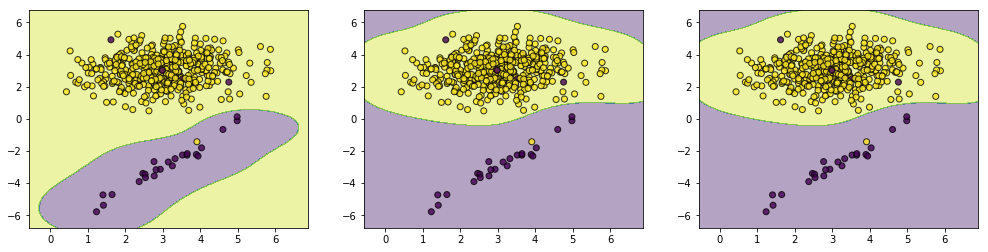

In [6]:
plt.figure(figsize = (17,4))
plt.subplot(1,3,1)
plot_decision_function(X=X,y=y,clf=svc,plt=plt)
plt.subplot(1,3,2)
plot_decision_function(X=X,y=y,clf=svc_multi,plt=plt)
plt.subplot(1,3,3)
plot_decision_function(X=X,y=y,clf=svc_add,plt=plt)